<a href="https://colab.research.google.com/github/armen1s/BOT/blob/main/CatB_Test4_Iter_25_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libs

In [ ]:
#@title Install libs
!pip install catboost
!pip install ccxt

"""
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
"""

!pip install TA-Lib-Precompiled
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
blosc2 3.4.0 requires numpy>=1.2

In [ ]:
from logging import warning
#@title Load libs
import numpy as np

# Data Management
import pandas as pd

# Machine Learning
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

#Sampling Methods
from imblearn.over_sampling import ADASYN

#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay as plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

from hyperopt import fmin, tpe, hp
from pandas_datareader.data import DataReader

import json
from datetime import datetime
import talib as ta
import ccxt

import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle as pk
import joblib

#Functions

In [ ]:
    def get_indicators(data, timeframes, volatility_look_back):
        df=data.copy()
        for timeframe in timeframes:
            #for frame_name in frames_names:
                df[f'ATR_{timeframe}'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
                df[f'RSI_{timeframe}'] = ta.RSI(df['close'], timeperiod=timeframe)
                df[f'ROC_{timeframe}'] = ta.ROC(df['close'], timeperiod=timeframe)
                df[f'EWO_{timeframe}'] = ta.SMA(df['close'], timeperiod=(timeframe+5)) - ta.SMA(df['close'], timeperiod=(timeframe+35))
                df[f'CCI_{timeframe}']  = ta.CCI(df['high'], df['low'], df['close'], timeperiod=timeframe)
                # --- DPO (Detrended Price Oscillator) ---
                # DPO пытается устранить тренд из цены для выявления циклов.
                offset = timeframe // 2 + 1
                sma = df['close'].rolling(window=timeframe).mean()
                df[f'DPO_{timeframe}'] = df['close'].shift(offset) - sma
                # Фича для определения флэта на основе DPO
                dpo_range = df[f'DPO_{timeframe}'].rolling(window=timeframe).apply(lambda x: x.max() - x.min(), raw=False)
                df[f'DPO_flat_{timeframe}'] = (dpo_range < (df[f'ATR_{timeframe}'] * 0.1)).astype(int) # Флэт, если диапазон DPO очень мал


        df["returns"] = (df["close"] / df["close"].shift(volatility_look_back)) - 1
        df["range"] = (df["high"] / df["low"]) - 1
        df["volatility"] = df['returns'].rolling(window=volatility_look_back).std()


        df['ADL'] = ta.AD(df['high'], df['low'], df['close'], df['volume'])


        # Momentum-Based Indicators
        df['Stoch_Oscillator'] = ta.STOCH(df['high'], df['low'], df['close'])[0]
        df['ADX']  = ta.ADX(df['high'], df['low'], df['close'], timeperiod=volatility_look_back)




        # Trend-Based Indicator
        df['PSAR'] = ta.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)


        #Flat
        df['range_abs']   = df['high'] - df['low']
        df['candle_body'] = (df['open'] - df['close']).abs()

        return df

In [ ]:
#@title New Mark Function
def get_shifts(df, K=4): #(data, K=4):
    #df=data.copy()
    for i in range(K):
        name_back=f'shift_{i}'
        name_frorward=f'shift_-{i}'
        df[name_back]=df['close'].shift(i)
        df[name_frorward]=df['close'].shift(-i)
    df.dropna(inplace=True)
    #return df

def get_coefs(df, K=4): #data, K=4):
    #df=data.copy()

    #get means
    back_col_names=[f'shift_{i}' for i in range(K)]
    frorward_col_names=[f'shift_-{i}' for i in range(K)]
    back_result=[i.mean() for i in df[back_col_names].values]
    frorward_result=[i.mean() for i in df[frorward_col_names].values]
    df['mean_back']=back_result
    df['mean_frorward']=frorward_result

    #get coefs
    df['coef']=(df['mean_frorward']-df['mean_back'])/df['mean_back']
    #return df

def get_classes(df,std_corrector=1): #data, std_corrector=1):
    #df=data.copy()
    long_thold=df['coef'][df['coef']>=0].mean()-df['coef'][df['coef']>=0].std()/std_corrector
    short_thold=df['coef'][df['coef']<0].mean()+df['coef'][df['coef']<0].std()/std_corrector
    df['target']=0
    df['target'][df['coef']>long_thold]=1
    df['target'][df['coef']<short_thold]=2 #-1
    #return df

def get_lbls(data, K=4, std_corrector=1):
    df=data.copy()
    get_shifts(df, K)
    get_coefs(df, K)
    get_classes(df, std_corrector)

    return df

In [ ]:
def add_indicators(data,
                   timeframes = [2, 4, 6, 7, 8, 9, 10, 12, 14, 16, 18, 22, 30, 36, 42],
                   volatility_look_back = 2):
        df_w_indicators=get_indicators(data,
                                   timeframes,
                                   volatility_look_back)
        df_w_indicators.dropna(inplace=True)

        # Apply np.isinf and np.isnan to numerical columns only
        numerical_cols = df_w_indicators.select_dtypes(include=np.number).columns
        # Recalculate inf_mask using df_cleaned instead of df_w_indicators
        inf_mask = np.isinf(df_w_indicators[numerical_cols]) | np.isnan(df_w_indicators[numerical_cols])

        # Update the rest of the code accordingly
        df_cleaned = df_w_indicators[~inf_mask.any(axis=1)]
        # Use numerical_cols for column selection to ensure alignment
        df = df_cleaned.loc[:, numerical_cols[~inf_mask.any(axis=0)]]
        df.dropna(inplace=True)
        return df


#Data preparation

In [ ]:
#@title Read csv
five_min_df = pd.read_csv('/content/5m_2025-04-29_2025-06-18_bybit_btcusdt_ohlcv.csv')

# Удаляем строки, где timestamp равен '2' (или содержит некорректные данные)
five_min_df = five_min_df[five_min_df['timestamp'] != '2']

# Удаляем строки с пустым volume
five_min_df = five_min_df.dropna(subset=['volume'])

# Преобразуем столбец 'timestamp' в datetime
five_min_df['timestamp'] = pd.to_datetime(five_min_df['timestamp'])

# Устанавливаем столбец 'timestamp' в качестве индекса
five_min_df.set_index('timestamp', inplace=True)

five_min_df = five_min_df.tail(9000)

print(f"Исходный размер DataFrame: {len(five_min_df)}")


Исходный размер DataFrame: 9000


In [ ]:
#@title Primary split
train_splitter=round(len(five_min_df)*0.7)
train=five_min_df.iloc[:train_splitter]


val_splitter=round(len(five_min_df)*0.85)
val=five_min_df.iloc[:val_splitter]

test=five_min_df.copy()

In [ ]:
#@title Adding indicators to train/test/val
train_w_ind=add_indicators(train)
val_w_ind=add_indicators(val)
test_w_ind=add_indicators(test)

/tmp/ipython-input-65-2497764656.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Supertrend_trend_{timeframe}'] = np.where(in_uptrend, 1, -1)
/tmp/ipython-input-65-2497764656.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'ATR_{timeframe}'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
/tmp/ipython-input-65-2497764656.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

In [ ]:
#@title Add target (New)

STD_CORRECTOR = 2 #@param {type: "integer"}
K = 4 #@param {type: "integer"}

train_input=get_lbls(train_w_ind, K=K, std_corrector=STD_CORRECTOR)
val_input=get_lbls(val_w_ind, K=K, std_corrector=STD_CORRECTOR)
test_input=get_lbls(test_w_ind, K=K, std_corrector=STD_CORRECTOR)
train_input=train_input.reset_index()
val_input=val_input.reset_index()
test_input=test_input.reset_index()

drop_cols=[f'shift_-{i}' for i in range(K)]
#drop_cols.append('mean_frorward')
test_input=test_input.drop(columns=drop_cols)
val_input=val_input.drop(columns=drop_cols)
train_input=train_input.drop(columns=drop_cols)


#keys=list(train_input.keys())
#keys.append('target')
#df.head()
#df['target'].hist()

/tmp/ipython-input-66-450657997.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['target'][df['coef']>long_thold]=1
/tmp/ipython-input-66-450657997.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

<Axes: >

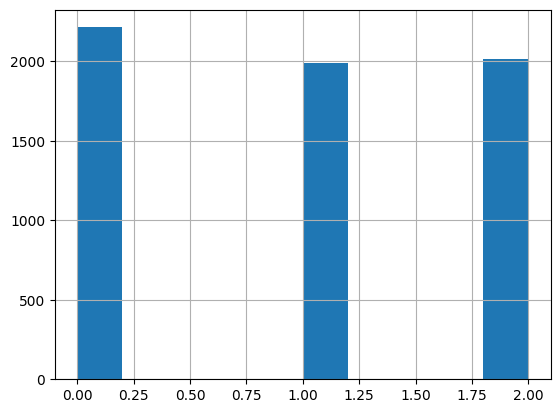

In [ ]:
#@title Look at class balance
train_input['target'].hist()

#Train

In [ ]:
#@title StandardScaler + Final split
scaler = StandardScaler()

train_target=train_input.iloc[:, -1].copy()
train_input=train_input.iloc[:,1 : -3].copy() # -3 to exclude coef and mean_forward

train_input=scaler.fit_transform(train_input)

val_target=val_input.iloc[:, -1].copy()
val_input=val_input.iloc[:,1 : -3].copy()
val_input=scaler.transform(val_input)
val_target=val_target.iloc[train_splitter:]
val_input=val_input[train_splitter:]

test_target=test_input.iloc[:, -1].copy()
test_input=test_input.iloc[:,1 : -3].copy()
test_input=scaler.transform(test_input)
test_target=test_target.iloc[val_splitter:]
test_input=test_input[val_splitter:]

In [106]:
#@title Set models and Run train
rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight={0: 1, 1: 4, 2: 4},  # приоритет: 0 ≫ 2 ≫ 1
    n_jobs=-1,
    random_state=42,
    bootstrap = False,
)

gb_classifier = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    max_depth=6,
    random_state=42
    # классические sklearn модели не имеют параметра class_weight — передадим ниже
)

catboost_classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.07,
    depth=8,
    l2_leaf_reg=3,
    border_count=128,
    rsm = 0.9,
    bagging_temperature=0.7,
    random_strength=0.5,
    boosting_type='Ordered',
    leaf_estimation_iterations=10,
    leaf_estimation_method='Newton',
    class_weights=[ 1, 4, 4],  # порядок: [0, 1, 2]
    verbose=0,
    random_state=42,
)

classifiers = [('Random Forest', rf_classifier),
               ('Gradient Boosting', gb_classifier),
               ('CatBoost', catboost_classifier)]

voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')

# если ты хочешь, чтобы веса работали и в GradientBoostingClassifier, — добавь:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0: 1, 1: 4, 2: 4}, y=train_target)

# Train the VotingClassifier on the training data
voting_classifier.fit(train_input, train_target, sample_weight=sample_w)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight={0: 1, 1: 4,
                                                                   2: 4},
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=6,
                                                         n_estimators=300,
                                                         random_state=42,
                                                         subsample=0.8)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7f2670278250>)],
                 voting='soft')

Ensemble Accuracy: 0.5686119873817035
Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       0.65      0.27      0.38       958
           1       0.54      0.73      0.63       741
           2       0.56      0.77      0.65       837

    accuracy                           0.57      2536
   macro avg       0.59      0.59      0.55      2536
weighted avg       0.59      0.57      0.54      2536

Confusion Matrix (Entire Dataset):
[[256 331 371]
 [ 65 544 132]
 [ 71 124 642]]
Confusion Matrix - Entire Dataset:


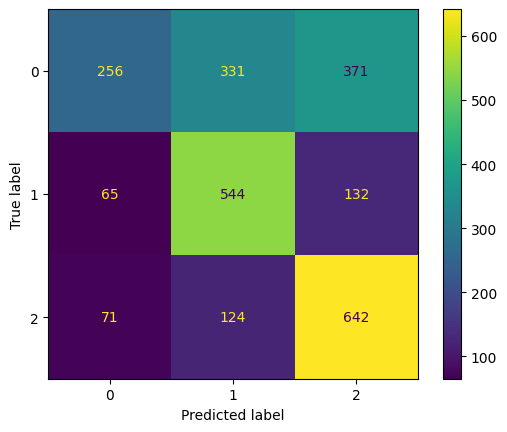

In [107]:
#@title Test (new) (StandartSclaer)
pred_target = voting_classifier.predict(np.vstack((val_input,test_input)))
accuracy = accuracy_score(np.hstack((val_target.values, test_target.values)), pred_target)
print("Ensemble Accuracy:", accuracy)


print("Classification Report (Entire Dataset):")
print(classification_report(np.hstack((val_target.values, test_target.values)), pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target))
cm_target = confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()

In [116]:
#@title Save VC
joblib.dump(voting_classifier, 'voting_classifier_11042025.pkl')

['voting_classifier_11042025.pkl']

#Spliting test array to test1 as val and test2 as main test. Using val to search right confidence

In [108]:
predicted_classes = voting_classifier.predict(val_input)
predicted_probs = voting_classifier.predict_proba(val_input)

n_classes = predicted_probs.shape[1]
results_df = pd.DataFrame(predicted_probs, columns=[f'prob_class_{i}' for i in range(n_classes)])

# Добавляем истинные и предсказанные метки
results_df['true_target'] = val_target.values
results_df['predicted_target'] = predicted_classes

# Вычисляем уверенность: максимальное значение вероятности для каждого примера
results_df['confidence'] = predicted_probs.max(axis=1)

# Флаг: предсказание правильное или нет
results_df['correct'] = results_df['true_target'] == results_df['predicted_target']

# Вычисляем соотношение между максимальной и второй по величине вероятностью
# Сначала сортируем вероятности по каждой строке
sorted_probs = np.sort(predicted_probs, axis=1)
# Последний столбец — максимальное значение, предпоследний — второй максимум.
results_df['ratio_max_second'] = sorted_probs[:, -1] / sorted_probs[:, -2]

print(results_df.head())

   prob_class_0  prob_class_1  prob_class_2  true_target  predicted_target  \
0      0.795417      0.127365      0.077219            1                 0   
1      0.673626      0.299512      0.026862            0                 0   
2      0.373529      0.559639      0.066832            2                 1   
3      0.546175      0.052390      0.401435            2                 0   
4      0.182129      0.010315      0.807555            2                 2   

   confidence  correct  ratio_max_second  
0    0.795417    False          6.245193  
1    0.673626     True          2.249081  
2    0.559639    False          1.498249  
3    0.546175    False          1.360554  
4    0.807555     True          4.433963  


In [109]:
# Средняя уверенность
mean_confidence_correct = results_df[results_df['correct']]['confidence'].mean()
mean_confidence_wrong = results_df[~results_df['correct']]['confidence'].mean()

print("Средняя уверенность на верных предсказаниях:", mean_confidence_correct)
print("Средняя уверенность на ошибочных предсказаниях:", mean_confidence_wrong)

# Среднее соотношение вероятностей (макс/второй максимум)
mean_ratio_correct = results_df[results_df['correct']]['ratio_max_second'].mean()
mean_ratio_wrong = results_df[~results_df['correct']]['ratio_max_second'].mean()

print("Среднее соотношение (макс/второй максимум) на верных предсказаниях:", mean_ratio_correct)
print("Среднее соотношение (макс/второй максимум) на ошибочных предсказаниях:", mean_ratio_wrong)

Средняя уверенность на верных предсказаниях: 0.6952878778658974
Средняя уверенность на ошибочных предсказаниях: 0.583002815131439
Среднее соотношение (макс/второй максимум) на верных предсказаниях: 6.0912185274405255
Среднее соотношение (макс/второй максимум) на ошибочных предсказаниях: 2.7506842521843446


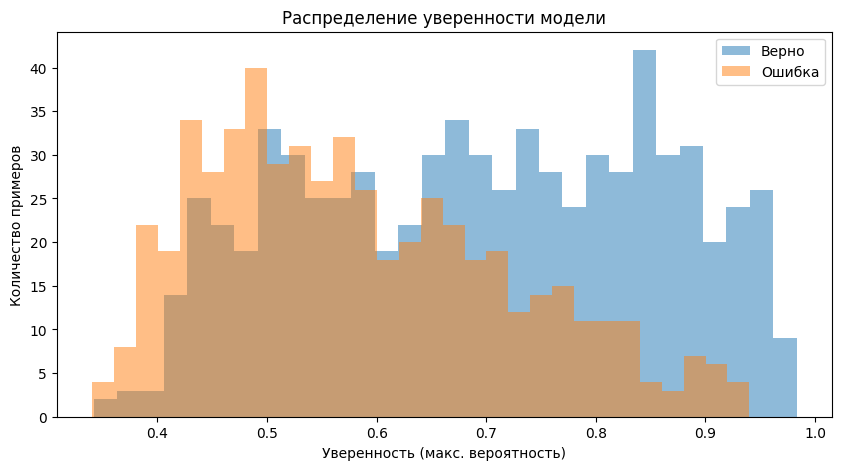

In [110]:
plt.figure(figsize=(10, 5))

# Гистограмма для верных предсказаний
plt.hist(results_df[results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Верно')

# Гистограмма для ошибочных предсказаний
plt.hist(results_df[~results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Уверенность (макс. вероятность)')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности модели')
plt.legend()
plt.show()

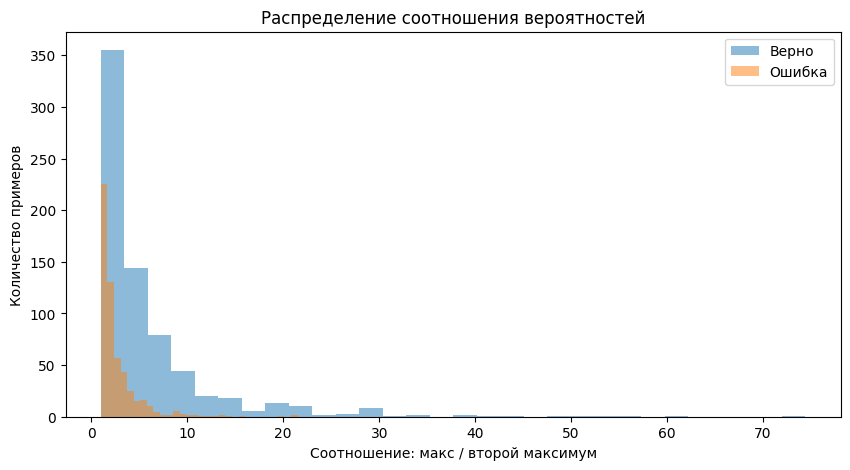

In [111]:
plt.figure(figsize=(10, 5))

plt.hist(results_df[results_df['correct']]['ratio_max_second'], bins=30, alpha=0.5, label='Верно')
plt.hist(results_df[~results_df['correct']]['ratio_max_second'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Соотношение: макс / второй максимум')
plt.ylabel('Количество примеров')
plt.title('Распределение соотношения вероятностей')
plt.legend()
plt.show()

#Using test with val confidence to predict classes 1 and 2

In [112]:
predicted_classes2 = voting_classifier.predict(test_input)
predicted_probs2 = voting_classifier.predict_proba(test_input)

n_classes = predicted_probs2.shape[1]
results_df2 = pd.DataFrame(predicted_probs2, columns=[f'prob_class_{i}' for i in range(n_classes)])

# Добавляем истинные и предсказанные метки
results_df2['true_target'] = test_target.values
results_df2['predicted_target'] = predicted_classes2

# Вычисляем уверенность: максимальное значение вероятности для каждого примера
results_df2['confidence'] = predicted_probs2.max(axis=1)

# Флаг: предсказание правильное или нет
results_df2['correct'] = results_df2['true_target'] == results_df2['predicted_target']

sorted_probs = np.sort(predicted_probs2, axis=1)
# Последний столбец — максимальное значение, предпоследний — второй максимум.
results_df2['ratio_max_second'] = sorted_probs[:, -1] / sorted_probs[:, -2]

print(results_df2.head())

   prob_class_0  prob_class_1  prob_class_2  true_target  predicted_target  \
0      0.138227      0.250374      0.611398            2                 2   
1      0.092057      0.077109      0.830834            2                 2   
2      0.107252      0.101266      0.791481            2                 2   
3      0.070796      0.011540      0.917664            1                 2   
4      0.190650      0.603699      0.205651            1                 1   

   confidence  correct  ratio_max_second  
0    0.611398     True          2.441937  
1    0.830834     True          9.025179  
2    0.791481     True          7.379631  
3    0.917664    False         12.962092  
4    0.603699     True          2.935557  


In [113]:
filtered_df = results_df2[(results_df2['true_target'].isin([1, 2])) & (results_df2['confidence'] > mean_confidence_correct)]
accuracy_filtered = filtered_df['correct'].mean()

print('Всего наблюдений в второй части тестовой выборки: '+str(len(np.vstack((val_input,test_input)))))
print('Всего меток 1 и 2 проставлено моделью: '+str(len(results_df2[(results_df2['true_target'].isin([1, 2]))])))
print('Всего меток, проставленных моделью, осталось после фильтрации: '+str(len(filtered_df)))
print()
print(f"Точность для классов 1 и 2 при уверенности > {mean_confidence_correct}:", accuracy_filtered)

Всего наблюдений в второй части тестовой выборки: 2536
Всего меток 1 и 2 проставлено моделью: 760
Всего меток, проставленных моделью, осталось после фильтрации: 348

Точность для классов 1 и 2 при уверенности > 0.6952878778658974: 0.9224137931034483


/tmp/ipython-input-65-2497764656.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Supertrend_trend_{timeframe}'] = np.where(in_uptrend, 1, -1)
/tmp/ipython-input-65-2497764656.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'ATR_{timeframe}'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
/tmp/ipython-input-65-2497764656.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

Топ-20 важных признаков из модели CatBoost:
              Признак  Важность
6               RSI_2  4.243138
149            EWO_42  2.814171
21              DPO_4  2.380786
8               ROC_2  1.874547
160  Stoch_Oscillator  1.726754
155           returns  1.708541
141            DPO_36  1.684187
111            DPO_18  1.636458
151            DPO_42  1.621466
159               ADL  1.585114
91             DPO_14  1.467509
158               OBV  1.464963
11              DPO_2  1.434596
4              volume  1.394129
164       candle_body  1.379939
139            EWO_36  1.313778
161               ADX  1.248861
20              CCI_4  1.228257
51              DPO_8  1.165336
16              RSI_4  1.158887


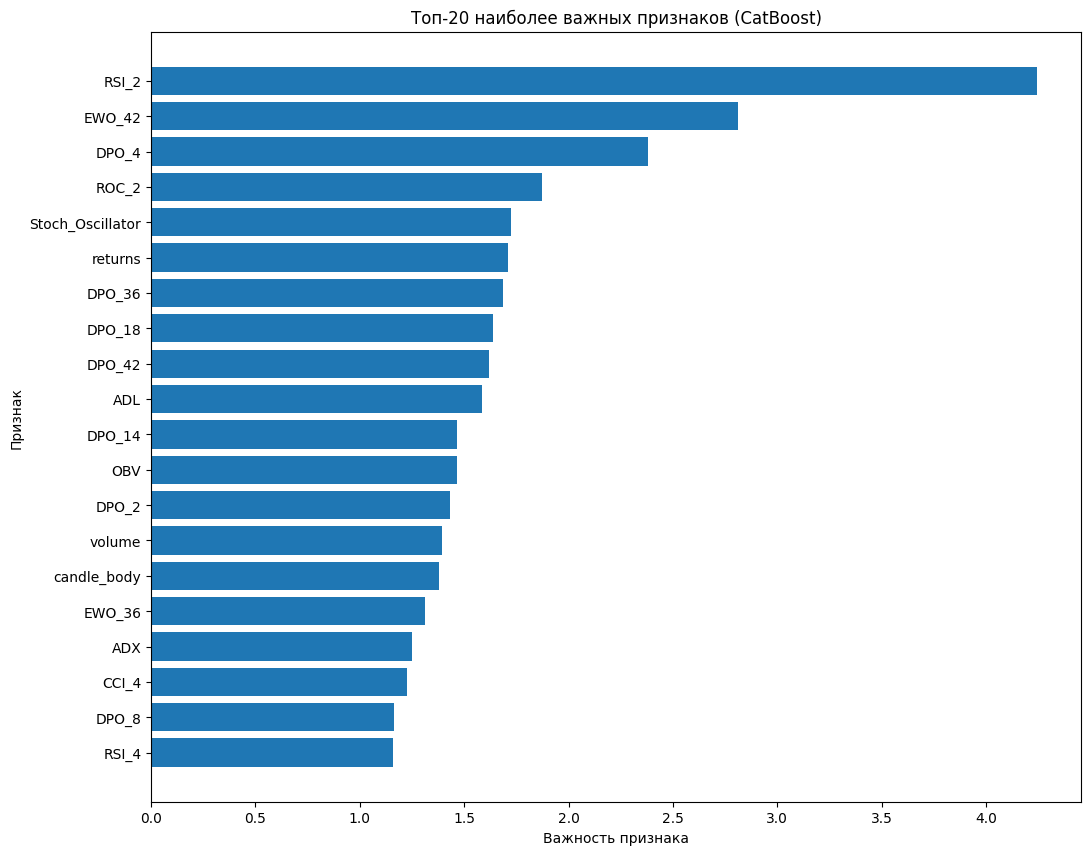

In [114]:
#@title Просмотр важности признаков

# Поскольку переменная train_input была преобразована в массив numpy,
# необходимо заново создать DataFrame с признаками, чтобы получить их названия.
# Этот код не обучает модель заново, а только получает названия столбцов для анализа.
_train_w_ind = add_indicators(train)
_train_lbls = get_lbls(_train_w_ind, K=K, std_corrector=STD_CORRECTOR)
_train_lbls = _train_lbls.reset_index()
_drop_cols = [f'shift_-{i}' for i in range(K)]
_train_lbls = _train_lbls.drop(columns=_drop_cols)
feature_names = _train_lbls.iloc[:,1 : -3].columns


# Извлечение обученной модели CatBoost из ансамбля
catboost_model = voting_classifier.named_estimators_['CatBoost']

# Получение значений важности признаков
feature_importances = catboost_model.feature_importances_

# Создание DataFrame для анализа и визуализации
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
}).sort_values(by='Важность', ascending=False)

# Вывод 20 самых важных признаков
print("Топ-20 важных признаков из модели CatBoost:")
print(importance_df.head(20))

# Построение графика
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.barh(importance_df['Признак'].head(20), importance_df['Важность'].head(20))
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Топ-20 наиболее важных признаков (CatBoost)')
plt.gca().invert_yaxis()
plt.show()

/tmp/ipython-input-65-2497764656.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Supertrend_trend_{timeframe}'] = np.where(in_uptrend, 1, -1)
/tmp/ipython-input-65-2497764656.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'ATR_{timeframe}'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
/tmp/ipython-input-65-2497764656.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

--- Топ-20 важных признаков для модели: Random Forest ---
              Признак  Важность
6               RSI_2  0.072383
20              CCI_4  0.048499
155           returns  0.044942
8               ROC_2  0.043442
16              RSI_4  0.032680
40              CCI_7  0.029282
30              CCI_6  0.027327
11              DPO_2  0.024161
10              CCI_2  0.022262
18              ROC_4  0.020832
50              CCI_8  0.017999
26              RSI_6  0.017801
21              DPO_4  0.015017
60              CCI_9  0.013236
36              RSI_7  0.012677
46              RSI_8  0.011919
56              RSI_9  0.010291
80             CCI_12  0.010169
70             CCI_10  0.009163
160  Stoch_Oscillator  0.009150


--- Топ-20 важных признаков для модели: Gradient Boosting ---
              Признак  Важность
6               RSI_2  0.301733
8               ROC_2  0.025027
20              CCI_4  0.024153
21              DPO_4  0.021767
155           returns  0.018839
164       cand

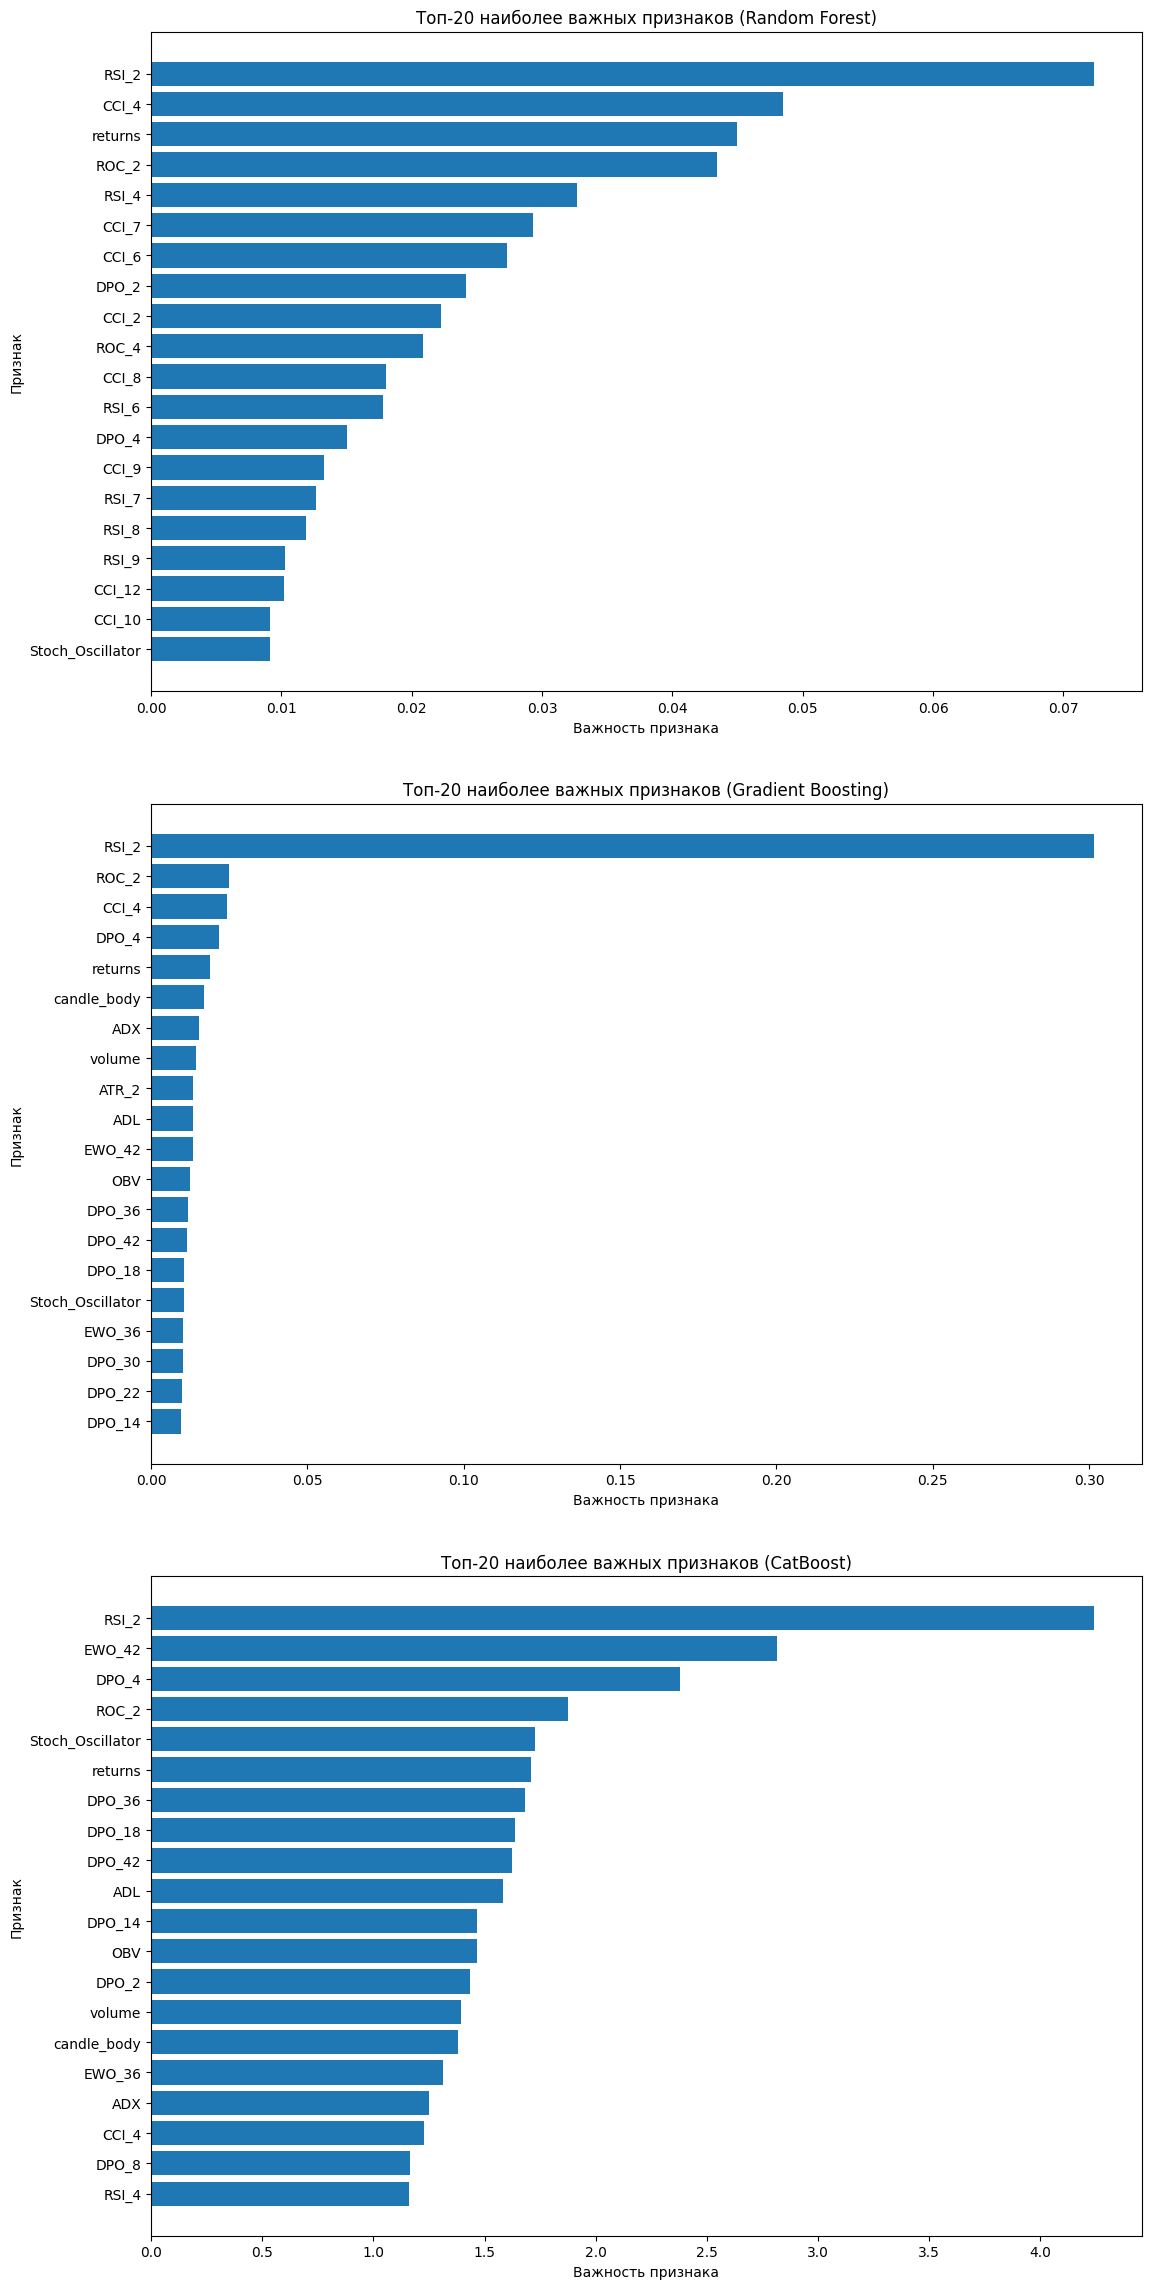

In [115]:
#@title Просмотр важности признаков для каждой модели

# Поскольку переменная train_input была преобразована в массив numpy,
# необходимо заново создать DataFrame с признаками, чтобы получить их названия.
# Этот код не обучает модели заново, а только получает названия столбцов для анализа.
_train_w_ind = add_indicators(train)
_train_lbls = get_lbls(_train_w_ind, K=K, std_corrector=STD_CORRECTOR)
_train_lbls = _train_lbls.reset_index()
_drop_cols = [f'shift_-{i}' for i in range(K)]
_train_lbls = _train_lbls.drop(columns=_drop_cols)
feature_names = _train_lbls.iloc[:,1 : -3].columns


# --- Анализ важности признаков для каждой модели ---

import matplotlib.pyplot as plt

# Получаем словарь с обученными моделями из ансамбля
estimators = voting_classifier.named_estimators_

# Отбираем только те модели, которые имеют атрибут feature_importances_
models_with_importance = {
    name: model for name, model in estimators.items()
    if hasattr(model, 'feature_importances_')
}

if not models_with_importance:
    print("Ни одна из моделей в ансамбле не имеет атрибута для вычисления важности признаков.")
else:
    # Создаем фигуру с подграфиками для каждой модели
    fig, axes = plt.subplots(
        nrows=len(models_with_importance),
        ncols=1,
        figsize=(12, 8 * len(models_with_importance))
    )
    # Если у нас только одна модель, axes не будет массивом
    if len(models_with_importance) == 1:
        axes = [axes]

    fig.tight_layout(pad=6.0) # Добавляем пространство между графиками

    # Проходим по каждой модели, вычисляем и выводим важность признаков
    for i, (name, model) in enumerate(models_with_importance.items()):
        # Получение значений важности
        importances = model.feature_importances_

        # Создание DataFrame для анализа
        importance_df = pd.DataFrame({
            'Признак': feature_names,
            'Важность': importances
        }).sort_values(by='Важность', ascending=False)

        # Вывод таблицы с топ-20 признаками
        print(f"--- Топ-20 важных признаков для модели: {name} ---")
        print(importance_df.head(20))
        print("\n" + "="*60 + "\n")

        # Построение графика на соответствующем подграфике
        ax = axes[i]
        top_20_df = importance_df.head(20)
        ax.barh(top_20_df['Признак'], top_20_df['Важность'])
        ax.set_xlabel('Важность признака')
        ax.set_ylabel('Признак')
        ax.set_title(f'Топ-20 наиболее важных признаков ({name})')
        ax.invert_yaxis()

    plt.show()

# Сообщаем о моделях, для которых важность не была рассчитана
for name in estimators:
    if name not in models_with_importance:
        print(f"\nПримечание: Модель '{name}' не имеет встроенного метода для вычисления важности признаков.")